**Author**: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

The PyMC3 model is adapted from https://github.com/pymc-devs/resources/blob/master/BCM/CaseStudies/PsychophysicalFunctions.ipynb


Todo: try for extero!

In [1]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.11.1

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy.stats import norm

sns.set_context('talk')

In [18]:
psychophysics_df = pd.read_csv('./data/HRD/test-data-cz/test_04_v20001/preprocessed.txt')

# Fitting a psychometric function at the subject level

In this example, we are going to fit a cummulative normal function to decision responses made during the Heart Rate Discrimination task. We are going to use the data from the [HRD method paper](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) (Legrand et al., 2021) and analyse the responses from one participant from the second session.

In [10]:
# Load data frame
psychophysics_df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

First, let's filter this data frame so we only keep subject 19 (`sub_0019` label) and the interoceptive condition (`Extero` label).

In [30]:
this_df = psychophysics_df[(psychophysics_df.Modality == 'Extero')] #& (psychophysics_df.Subject == 'sub_0019')]
this_df.head()

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,nTrials,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier
1,psi,Less,Extero,psi,Less,3.531375,66.0,2.261656,-0.5,62.0,...,1,22.805550,12.549457,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,False
2,psi,More,Extero,psi,More,4.382830,74.0,1.782385,22.5,85.5,...,2,10.001882,12.884902,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,False
3,psi,More,Extero,psi,More,4.749332,73.0,1.259700,10.5,54.0,...,3,0.998384,13.044744,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,False
4,psi,Less,Extero,psi,Less,4.166049,51.0,1.680286,-1.5,79.5,...,4,6.888851,11.541558,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,False
6,psi,More,Extero,psi,More,2.849930,60.0,1.074785,6.5,97.0,...,6,2.356668,11.093011,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,1.657200e+09,False


This data frame contain a large number of columns, but here we will be interested in the `Alpha` column (the intensity value) and the `Decision` column (the response made by the participant).

In [31]:
this_df = this_df[['Alpha', 'Decision']]
this_df.head()

,Alpha,Decision
1,-0.5,Less
2,22.5,More
3,10.5,More
4,-1.5,Less
6,6.5,More


These two columns are enought for us to extract the 3 vectors of interest to fit a psychometric function:
* The intensity vector, listing all the tested intensities values
* The total number of trials for each tested intensity value
* The number of "correct" response (here, when the decision == 'More').

Let's take a look at the data. This function will plot the proportion of "Faster" responses depending on the intensity value of the trial stimuli (expressed in BPM). Here, the size of the circle represent the number of trials that were presented for each intensity values.

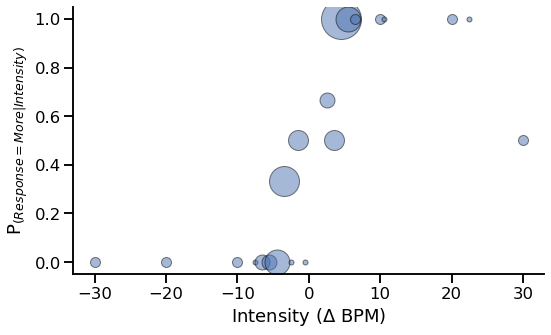

In [44]:
fig, axs = plt.subplots(figsize=(8, 5))
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', 
             markeredgecolor='k', markersize=total*5)
plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()

# Model

The model was defined by:

<img src="https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/psychophysics2.png" align = 'left' alt="drawing" width="200"/>

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \Phi_{i}(x_{i}, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i} - \alpha}{\beta * \sqrt{2}})$$
$$ \alpha \sim \mathcal{Uniform}(-40.5, 40.5)$$
$$ \beta \sim  |\mathcal{Normal}(0, 10)|$$

Where $erf$ denotes the [error functions](https://en.wikipedia.org/wiki/Error_function) and $\phi$ is the cumulative normal function.

We create our own PyMC3 compatible cumulative normal distribution function here.

In [45]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

We preprocess the data to extract the intensity $x$, the number or trials $n$ and number of hit responses $r$.



In [46]:
x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
    x[ii] = intensity
    n[ii] = sum(this_df.Alpha == intensity)
    r[ii] = sum((this_df.Alpha == intensity) & (this_df.Decision == "More"))

# remove no responses trials
validmask = n != 0
xij, nij, rij = x[validmask], n[validmask], r[validmask]

In [10]:
nij

array([2., 2., 2., 3., 2., 5., 2., 2., 3., 1., 1., 1., 3., 1., 1., 1., 2.,
       1., 1., 1., 3., 4., 5., 3., 2., 2., 1., 1., 2.])

In [11]:
xij

array([-30. , -20. , -14.5, -13.5, -12.5, -11.5, -10.5, -10. ,  -8.5,
        -7.5,  -6.5,  -5.5,  -4.5,  -1.5,  -0.5,   5.5,  10. ,  10.5,
        12.5,  13.5,  15.5,  16.5,  17.5,  18.5,  19.5,  20. ,  20.5,
        22.5,  30. ])

In [12]:
rij

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 2.,
       0., 1., 0., 2., 4., 5., 3., 2., 2., 1., 1., 2.])

Create the model and sample.

In [47]:
with pm.Model():

    alpha = pm.Uniform("alpha", lower=-40.5, upper=40.5)
    beta = pm.HalfNormal("beta", 10)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(xij, alpha, beta)
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=nij, observed=rij)
    trace = pm.sample(
        chains=4, cores=4, tune=2000, draws=4000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

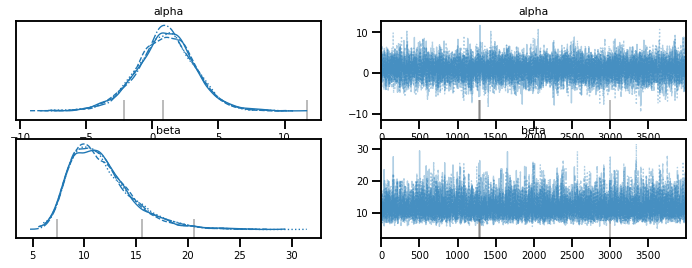

In [48]:
az.plot_trace(trace, var_names=['alpha', 'beta'])

In [49]:
stats = az.summary(trace, ["alpha", "beta"])
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.014,2.215,-3.098,5.294,0.024,0.019,8862.0,7888.0,1.0
beta,11.628,3.020,6.958,17.497,0.032,0.023,9347.0,9453.0,1.0


**Interpretation**: Here, $\alpha$ refers to the threshold value (also the point of subjective equality for this design). This participant had a threshold at estimated at 2.25, which is just slightly positively biased. The $\beta$ value refers to the slope. A higher value means lower precision. Here, the slope is estimated to be around 7.46 for this participant.

# Plotting
Extrace the last 10 sample of each chain (here we have 4).

In [50]:
alpha_samples = trace["posterior"]["alpha"].values[:, -10:].flatten()
beta_samples = trace["posterior"]["beta"].values[:, -10:].flatten()

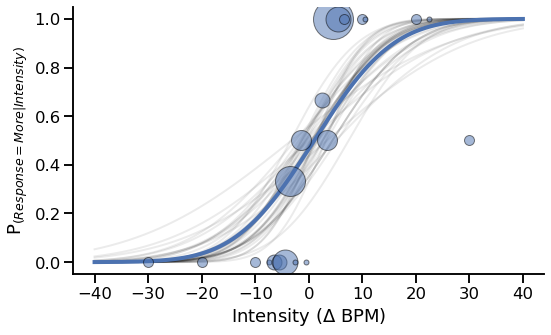

In [51]:
fig, axs = plt.subplots(figsize=(8, 5))

# Draw some sample from the traces
for a, b in zip(alpha_samples, beta_samples):
  axs.plot(np.linspace(-40, 40, 500), 
          (norm.cdf(np.linspace(-40, 40, 500), loc=a, scale=b)),
          color='k', alpha=.08, linewidth=2)

# Plot psychometric function with average parameters
slope = stats['mean']['beta']
threshold = stats['mean']['alpha']
axs.plot(np.linspace(-40, 40, 500), 
        (norm.cdf(np.linspace(-40, 40, 500), loc=threshold, scale=slope)),
         color='#4c72b0', linewidth=4)

# Draw circles showing response proportions
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', 
             markeredgecolor='k', markersize=total*5)

plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()